# Familiarizing Myself with PyTorch

The point of this notebook is to familiarize myself with pytorch for future project. In this notebook is an implementation of an autoencoder using torch.

In [6]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

The below cell loads in the mnist dataset form torchvision.datasets.mnist, it specifies that we want to get the training set, down load it, and transofrm it from a PIL image into a tensor. 

Pytorch uses the below DataLoader function to load data into batches. This is similar to how image_data_generator works in tensorflow. 

In [2]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='.', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

#Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

100%|██████████| 9912422/9912422 [00:04<00:00, 2133675.10it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14441546.71it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1652462.99it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 1518938.67it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In PyTorch, the nn module takes fills a similar role to keras in tensorflow. Below, we define a class Autoencoder that, when instantiated, defines the model architectures of the encoder and the decoder. The forward() method defined below the __init__ statement determines the forward pass of the model into the encoder and then into the decoder. This object oriented approach to defining the forward pass is one of the key differences in the usability of PyTorch vs Tensorflow.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()

Here, we define the loss and optimizer using the nn module. They are defined to be MSE and Adam

In [4]:
# Loss function and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Pytorch also gives you more control than tensorflow over how the model is trained. In keras, the fit function is used to train the model, but in PyTorch you define the training loop in a python for loop. 

Within a single epoch, the images generated from the train loader are reshaped into the correct shape for a linear model. Then the gradients are set to zero, a forward pass is made, the loss is calculated, the gradients are calculated in backprop, and the optimizer updates the weights.

In [7]:
# Training the Model
epochs = 1000

#early stopping
patience, counter, min_loss = 5, 0, np.Inf

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader): #load a batch of digits from the train_loader
        images = images.view(images.size(0), -1)  # Reshape input to (batch_size, 784) tensor for linear layers

        # Forward + Backward + Optimize'
        optimizer.zero_grad() #reset gradients to zero
        outputs = model(images) #forward pass of the model
        loss = criterion(outputs, images) #calculate the loss
        loss.backward() #backpropagate the loss
        optimizer.step() #update the weights

    # log
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    #early stopping
    if loss.item() < min_loss:
        min_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch: {epoch} \nFinal Loss was {loss.item():.4f}')
            break

print('Training completed')

Epoch 0, Loss: 0.0210
Epoch 1, Loss: 0.0174
Epoch 2, Loss: 0.0163
Epoch 3, Loss: 0.0161
Epoch 4, Loss: 0.0155
Epoch 5, Loss: 0.0157
Epoch 6, Loss: 0.0141
Epoch 7, Loss: 0.0152
Epoch 8, Loss: 0.0149
Epoch 9, Loss: 0.0154
Epoch 10, Loss: 0.0150
Epoch 11, Loss: 0.0150
Early stopping at epoch: 11 
Final Loss was 0.0150
Training completed


Below is a plot from the AE output against the input.

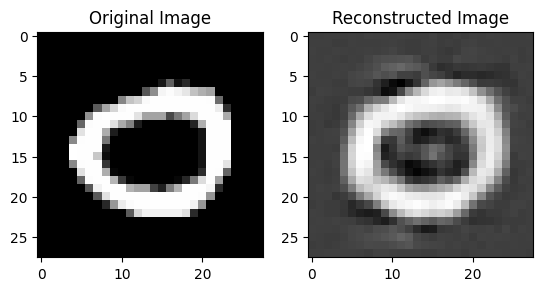

In [8]:
iterator = iter(train_loader)
images, labels = next(iterator) # get one batch of images and labels
image = images[0].view(-1) # flatten the first image and remove the batch dimension
decoded = model(image) # pass the reshaped image through the model

# Assuming that images[0] is of shape [1, 28, 28]
original_image = images[0].squeeze(0) # remove the batch dimension

# Visualize the original and reconstructed image
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(decoded.detach().numpy().reshape(28, 28), cmap='gray')
axes[1].set_title('Reconstructed Image')
plt.show()
